In [1]:
import pandas as pd               
import numpy as np                

import matplotlib.pyplot as plt   
import matplotlib
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# 1. Данные и пропуски 

На одном из предыдущих семинаров мы строили с вами визуализации для клипов с youtube. Сегодня мы продолжим с ним работать и попробуем предсказывать жарн видео по его параметрам. 

In [2]:
data = pd.read_csv('../data/youtube_data.csv', sep = '\t')
data.head()

title  caption  categoryId  \
0                          "#2Маши "Свободные линии"    False          10   
1          "ALARM" СЕРГЕЙ ЛАЗАРЕВ ( SERGEY LAZAREV )    False          10   
2  "EARTH SONG"  SERGEY LAZAREV. DEDICATED TO MIC...    False          10   
3             "Earth song" премия МУЗ-тВ 2010 (LIVE)    False          10   
4                     "FAKE" СЕРГЕЙ ЛАЗАРЕВ (SERGEY)    False          10   

   commentCount definition                                        description  \
0          34.0         hd                  ITUNES - https://itun.es/ru/0YzI_   
1           NaN         sd                         NEW OFFICIAL VIDEO\r\n2010   
2          26.0         sd  Посвящается Майклу Джексону...\r\nCover-versio...   
3          12.0         sd  Сергей Лазарев, La Toya Jackson,  Ани Лорак, Т...   
4          46.0         sd                                     official video   

   dislikeCount duration  license  licensedContent  ...  \
0          43.0  PT3M30S  youtube             True  ...   
1         690.0  PT3M42S  youtube            False  ...   
2          10.0  PT5M46S  youtube            False  ...   
3           7.0  PT6M16S  youtube            False  ...   
4          19.0     PT3M  youtube             True  ...   

   comment_mean_len_symbol comment_mean_len_word comment_negative_mean_prob  \
0                59.440000              8.840000                   0.635410   
1                      NaN                   NaN                        NaN   
2               120.000000             19.291667                   0.725987   
3                81.818182             11.545455                   0.736776   
4                43.735294              8.617647                   0.596008   

   comment_negative_share commentators_uniq comments_emoji_max  \
0                0.480000              24.0                9.0   
1                     NaN               NaN                NaN   
2                0.750000              23.0               13.0   
3                0.727273              11.0               13.0   
4                0.441176              33.0               23.0   

  comments_emoji_mean  comments_emoji_share  comments_obscene_cnt  \
0            1.000000              0.320000                   0.0   
1                 NaN                   NaN                   NaN   
2            0.666667              0.125000                   0.0   
3            1.181818              0.090909                   0.0   
4            0.794118              0.088235                   1.0   

   words_obscene_cnt  
0                0.0  
1                NaN  
2                0.0  
3                0.0  
4                1.0  

[5 rows x 30 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19124 entries, 0 to 19123
Data columns (total 30 columns):
title                         19124 non-null object
caption                       19124 non-null bool
categoryId                    19124 non-null int64
commentCount                  18914 non-null float64
definition                    19124 non-null object
description                   18339 non-null object
dislikeCount                  18850 non-null float64
duration                      19124 non-null object
license                       19124 non-null object
licensedContent               19124 non-null bool
likeCount                     18850 non-null float64
music_style                   19124 non-null object
performer                     19124 non-null object
publicStatsViewable           19124 non-null bool
publishedAt                   19124 non-null object
tags                          17806 non-null object
video_id                      19124 non-null object
viewCount  

Можно заметить, что некоторые данные у нас отсутствуют. Давайте посмотрим на заполненность нашей таблички на картинке. 

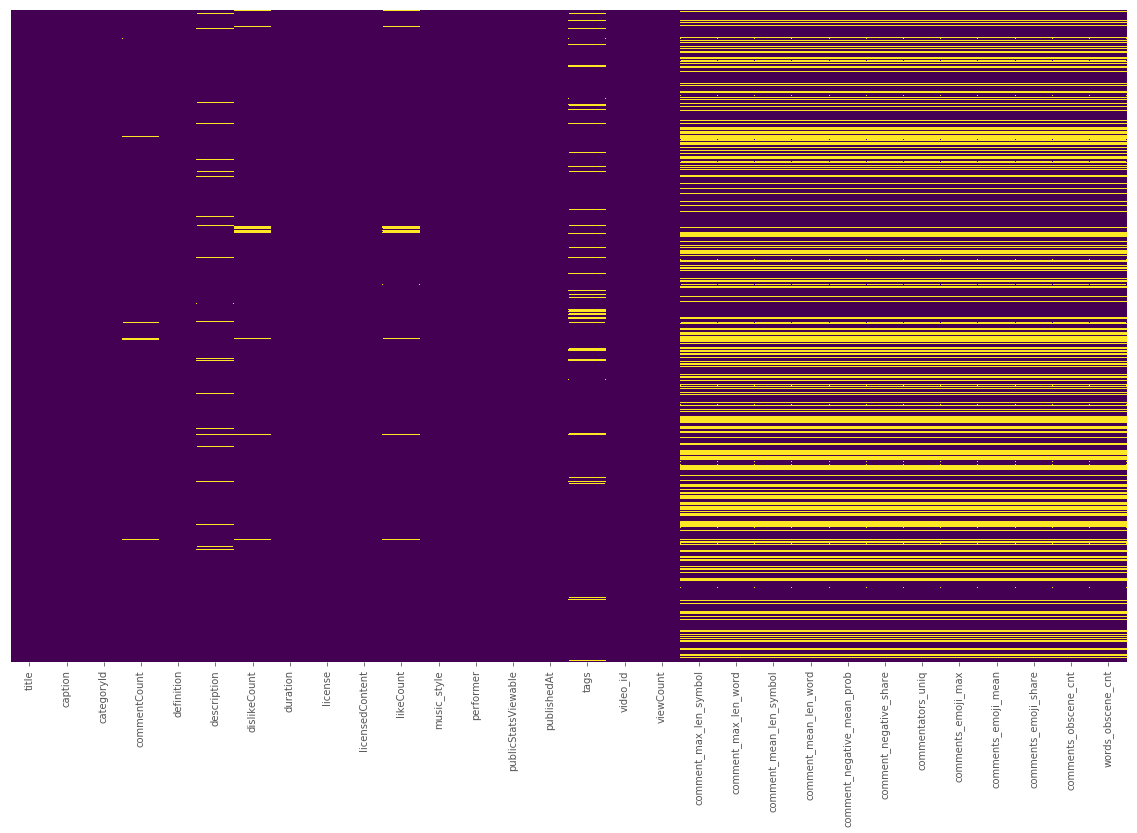

In [4]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Что мы говорим пропускам в данных? Не сегодня. С пропусками нужно бороться. Алгоритмы оцениваются на числах и не любят пропуски (некоторые настроены к пропускам нейтрально, так как умеют их обрабатывать). 

Первое решение: выбросить все наблюдения с пропусками. Проблема такого подхода в том, что другие то переменные для этих наблюдений не пропущены. Значит, выбросив строчки, соответствующие пропускам, мы потеряем кучу информации. Полезной информации. Информацию и без всех наших преобразований легко потерять, сложно найти и невозможно забыть, а мы её ещё и выкинуть хотим. 

Обычно, если пропусков в переменной не очень много, их заполняют чем-нибудь нейтральным. Например, средними или медианами. Когда алгоритм будет натыкаться на них, он будет думать: "Хммм, ну тут ничего особенного, всё как в среднем по выборке, пойду посмотрю другую переменную". И тогда всё будет хорошо. 

Для удобства создаём список из непрерывных переменных. Дальше будем работать только с ними.

In [5]:
real_variables = ["commentCount",              # число комментов под видосом
                  "dislikeCount",              # число дисолайков 
                  "likeCount",                 # лайки 
                  "viewCount",                 # просмотры 
                  "comment_max_len_symbol",    # максимальная длинна комента 
                  "comment_max_len_word",      # максимальное число слов в коменте 
                  "comment_mean_len_symbol",   # средняя длина комента
                  "comment_mean_len_word",     # среднее число слов в коменте 
                  "comment_negative_share",    # средяя доля негатива в коментах 
                  "comment_negative_mean_prob",# ещё одна переменная, отвечающая за негатив
                  "commentators_uniq",         # число уникальных коментаторов 
                  "comments_emoji_max",        # максимальное число эмодзи в коменте
                  "comments_emoji_mean",       # среднее число эмодзи 
                  "comments_emoji_share",      # доля коментов с эмодзи 
                  "comments_obscene_cnt",      # число матерных коментов 
                  "words_obscene_cnt"          # число матерных слов под видосом
                 ]

Давайте заполним во всех непрерывных переменных пропуски средними. 

In [ ]:
for column in real_variables:
    '''
    <YOUR CODE HERE!>
    '''

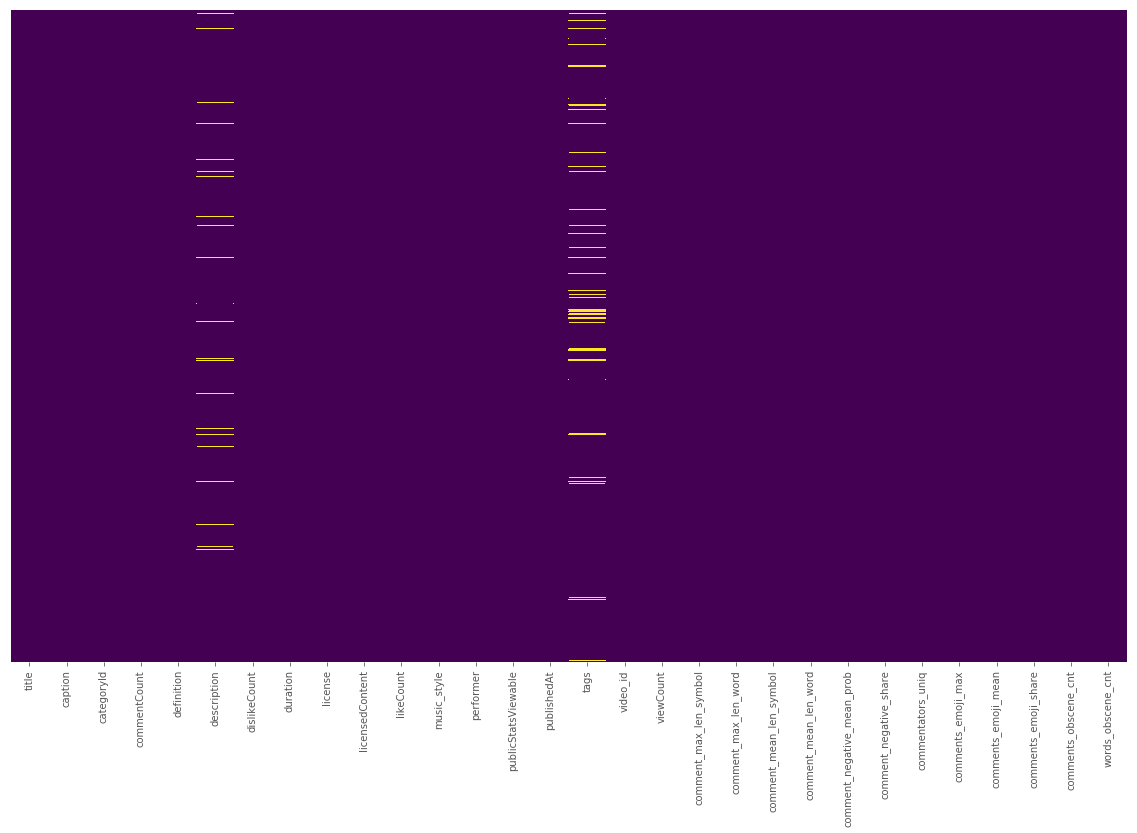

In [7]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# 2. Что будем предсказывать? 

Предсказывать будем жанр видео. Давайте посмотрим какие у нас есть жанры в данных. 

In [4]:
'''
<YOUR CODE HERE!>
'''

'\n<YOUR CODE HERE!>\n'

Давайте для простоты оставим в данных только два жанра. Например, рэп и эстраду. Попробуем заставить машины разбираться, что за видео перед ними. 

In [5]:
'''
<YOUR CODE HERE!>
'''

'\n<YOUR CODE HERE!>\n'

Разбиваем выборку на обучающую, в которой мы будем находить закономерности, и тестовую выборку, на которой мы будем проверять выявленные закономерности.

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state=201905)

print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер обучающей выборки: (4943, 30)
Размер тестовой выборки: (1236, 30)


Убедимся, что мы не нарушили пропорции жанров при делении выборки на тренировочную и тестову. __Как думаете, зачем это нужно?__ 

In [11]:
'''
<YOUR CODE HERE!>
'''

estrada    0.669836
rap        0.330164
Name: music_style, dtype: float64

In [12]:
'''
<YOUR CODE HERE!>
'''

estrada    0.679612
rap        0.320388
Name: music_style, dtype: float64

Вроде бы всё нормально. Сейчас в нашем датасете все жанры записаны в текстовом виде. Мы с вами постоянно повторяем, как прописную истину то, что __модели поедают только цифры.__ Давайте переработаем жанры в дамми-переменную. Будем обозначать рэпчик за $1$, попсу за $0$. 

In [13]:
'''
<YOUR CODE HERE!>
'''

array([0, 0, 1, ..., 0, 0, 0])

In [14]:
'''
<YOUR CODE HERE!>
'''

array([1, 0, 0, ..., 1, 0, 0])

# 3. Моделирование! 

Давайте строить прогнозные модели! 

In [16]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Он сам будет считать максимумы, минимумы и делить! 

# Объеявили скалировшик 
scaler = MinMaxScaler( )

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы, поделил)
scaler.fit(X_train) 

# Теперь применяем его к нашим данным 
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)


У модельки нас интересуют два метода: 
* `fit`- обучить модель
* `predict`- применить модель

## 3.2 Логистическая регрессия

In [6]:
from sklearn.linear_model import LogisticRegression

# объявляем метод 9 ближайших соседей
lr = LogisticRegression()

# обучаем его по выборке 
'''
<YOUR CODE HERE!>
'''
# строим для тестовой выборки прогнозы 
'''
<YOUR CODE HERE!>
'''

Взглянем на прогнозы. 

In [7]:
'''
<YOUR CODE HERE!>
'''

'\n<YOUR CODE HERE!>\n'

Интересно было бы узнать насколько качественной у нас получилась модель. Давайте посмотрим на какую-нибудь метрику качества, например на `accuracy`.  __Как думаете, это хорошая идея?__ 

In [8]:
from sklearn.metrics import accuracy_score

# считаем долю верно построенных прогнозов 
'''
<YOUR CODE HERE!>
'''

'\n<YOUR CODE HERE!>\n'

Давайте попробуем посчитать ещё и другую метрику. Например, площадь под roc-кривой. 

In [9]:
from sklearn.metrics import roc_auc_score

# считаем долю верно построенных прогнозов 
'''
<YOUR CODE HERE!>
'''

'\n<YOUR CODE HERE!>\n'

## 3.3 SVM деревья 

<img src = "http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528907338/classification-tree_ygvats.png">


In [25]:
# Подшружаем дерево 
from sklearn.svm import LinearSVC

# Объявляем  SVM 
svm = LinearSVC( )

# учим  
'''
<YOUR CODE HERE!>
'''

# предсказываем на тестовой выборке результаты 
'''
<YOUR CODE HERE!>
'''

# посчитали долю верных ответов
'''
<YOUR CODE HERE!>
'''

accuracy: 0.8656957928802589
roc_auc: 0.8457972582972584


# 4. Метрики классификации 

Только что мы построили два алгоритма и построили для них разные метрики. Давайте попробуем посравнивать их между собой с помощью оставшихся метрик классификации. 

Разные метрики качества мы с вами разобрали ранее. Если вы не поняли их, можно [глянуть лекцию Жени Соколова.](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/lecture/IVuAc/mietriki-kachiestva-klassifikatsii-1)  Расскажите потом понятной она вам показалась или непонятной, если будете смотреть.

Вкратце напомню о чём шла речь. Предсказывая отток, мы можем совершить ошибки двух видов: 

* Ошибка первого рода: мы предсказали человеку, что он уйдёт, а он остался.
* Ошибка второго рода: мы предсказали, что человек останется, а он ушёл.

В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. Мы с вами построили вот такую табличку  

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

и обсудили слудущие метрики качества: 

* Доля верно классифицированных объектов:

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту. 

* Точность (precision): 

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку. 

* Полнота (Recall): 

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение `Precision` не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня `False Positive`. `Recall` демонстрирует способность алгоритма обнаруживать данный класс вообще, а `Precision` — способность отличать этот класс от других классов.

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, на бы хотелось получить максимальную полноту. Нестрашно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру: 

* F-measure: 

$$F = \frac{\beta \cdot precision \cdot recall}{precision + recall}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

Все эти метрики уже есть в пакете sklearn. По уму надо бы реализовать их самостоятельно, чтобы лучше понять, но у нас на это нет особо времени, поэтому это домашнее задание :) 

Итак, посмотрим на наши чудо-метрики! Для начала подгрузим их. 

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

__Внимание!__ В ячейке ниже будет несколько страшных функций для красивых картинок. Вы не обязаны разбираться в том, как они устроены. Но вот понимать что эти картинки обозначают и как метрики классификации работают, вы обязаны. 

In [28]:
import itertools

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass


# Картинки для PR-кривой, а-меры и прочих ништяков
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

__Внимание!__ Страшный кодище для картинок закончился. Начиная с этой строки, нужно снова начать понимать. У нас есть три функции: 

* `plot_confusion_matrix` строит матрицу ошибок
* `roc_auc_pic` строит рок-кривую
* `plot_precision_recall_curve` строит кривую точнось-полнота

Начнём с моделей. Будем смотреть на две: случайный лес и ближайшие соседи. 

Здесь вместо `predict` мы будем использовать метод `predict_proba`, этот метод выдает вероятности принадлежности к каждому классу

In [29]:
# Начнёмс с того, что построим прогнозы 
'''
<YOUR CODE HERE!>
'''

Для каждой построим картинки и сравним их между собой. Начнём с roc-кривых. 

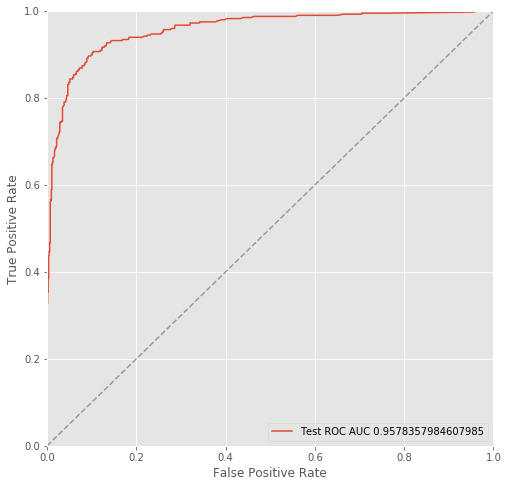

In [30]:
# Для леса
roc_auc_pic(, y_test)

__Какая из моделей показывает более высокое качество по метрике roc_auc?__ 

Теперь сравним модели по площади под precision-recall кривой.

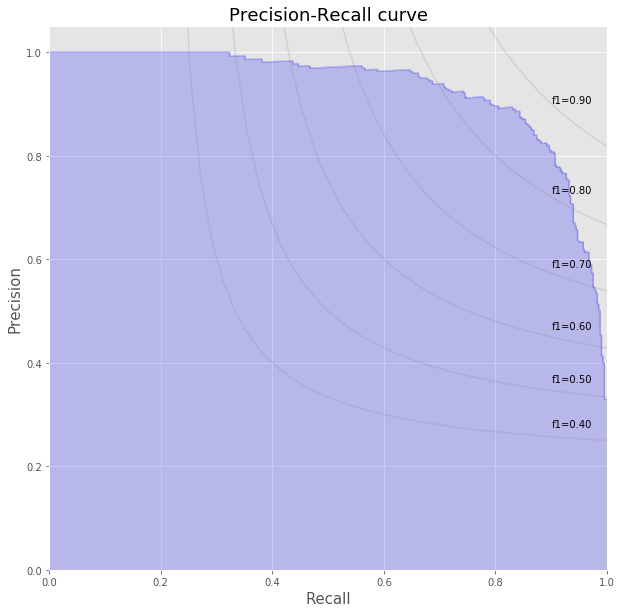

In [32]:
plot_precision_recall_curve(, y_test)

# Дополнительно посмотреть

https://habr.com/ru/company/ods/blog/484148/ <br>
https://habr.com/ru/company/io/blog/265007/ <br>
https://habr.com/ru/company/ods/blog/323890/#logisticheskaya-regressiya-kak-lineynyy-klassifikator